---
<div align="center">

# ML2 | Urban Sound Classification
</div>

---

<div align="center">
    
---
## Problem Formulation
---

</div>

> ADD PROBLEM FORMULATION


For each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation.

<div align="center">
    
---
## Project Dependencies
---

</div>

In [1]:
# Remove ipykernel
# !jupyter kernelspec uninstall tf -y

In [2]:
# Add ipykernel
# !python -m ipykernel install --name "tensorflowKernel"

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\gongas\anaconda3\envs\tensorflow\lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# !pip install tensorflow_hub

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as libr
import ast

from sklearn.model_selection import (train_test_split)
from sklearn.preprocessing import (LabelEncoder)

import tensorflow as tf
from tensorflow.keras.utils import (to_categorical)
from tensorflow.keras import (layers, models)
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
import tensorflow_hub as hub

from Utils.Configuration import (loadConfig, loadPathsConfig)

from DataPreProcessing.AudioManagement import (loadAudio, showcaseAudio)
from DataPreProcessing.FeatureExtraction import (extractMFCCs, extractAll1DimensionalData, extractAll2DimensionalData, extractImportantFeatures)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotFeatureDistributionByFold, plotAudioWave, plotAudio1DimensionalFeature, plotChromaFeatures, plotMelSpectrogram, plotSpectralContrast)

from ModelDevelopmentAndEvaluation.DataVisualization import (plotNetworkTrainingPerformance)


In [8]:
import sys
print(sys.executable)

C:\Users\Gongas\anaconda3\envs\Tensorflow\python.exe


In [9]:
# Load Configuration Dictionaries
config = loadConfig()
pathsConfig = loadPathsConfig()
config

{'DURATION': 4,
 'SAMPLE_RATE': 44100,
 'HOP_LENGTH': 551,
 'WINDOW_LENGTH': 1014,
 'N_FFT': 1024,
 'TIME_SIZE': 321,
 'N_CHROMA': 12,
 'N_MFCC': 13}

<div align="center">
    
---
## Exploratory Data Analysis
---

</div>

> PLAY AROUND WITH THE DATA

In [10]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
df[df['slice_file_name'] == '100032-3-0-0.wav']['class'].to_numpy()[0]

'dog_bark'

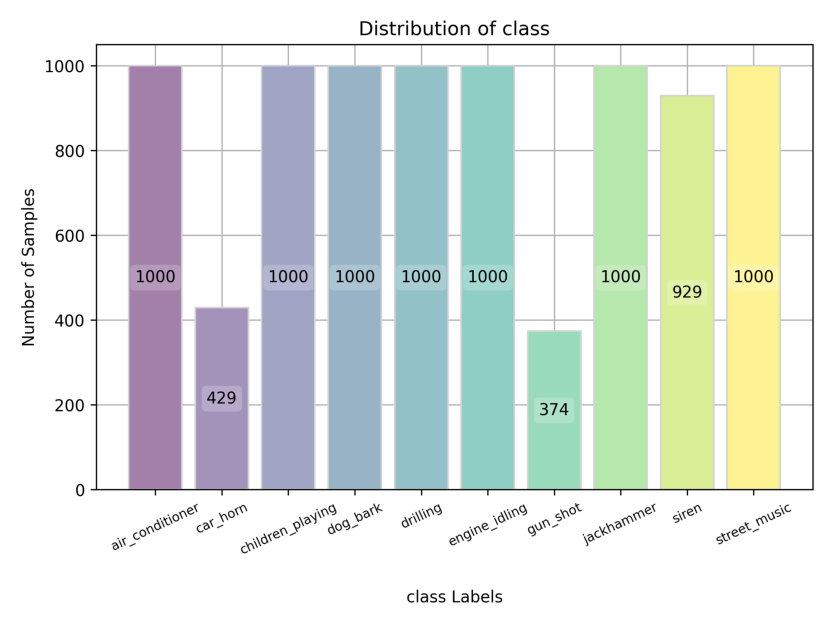

In [12]:
# Plot the distribution of the target class
plotFeatureDistribution(df=df, classFeature='class', pathsConfig=pathsConfig)

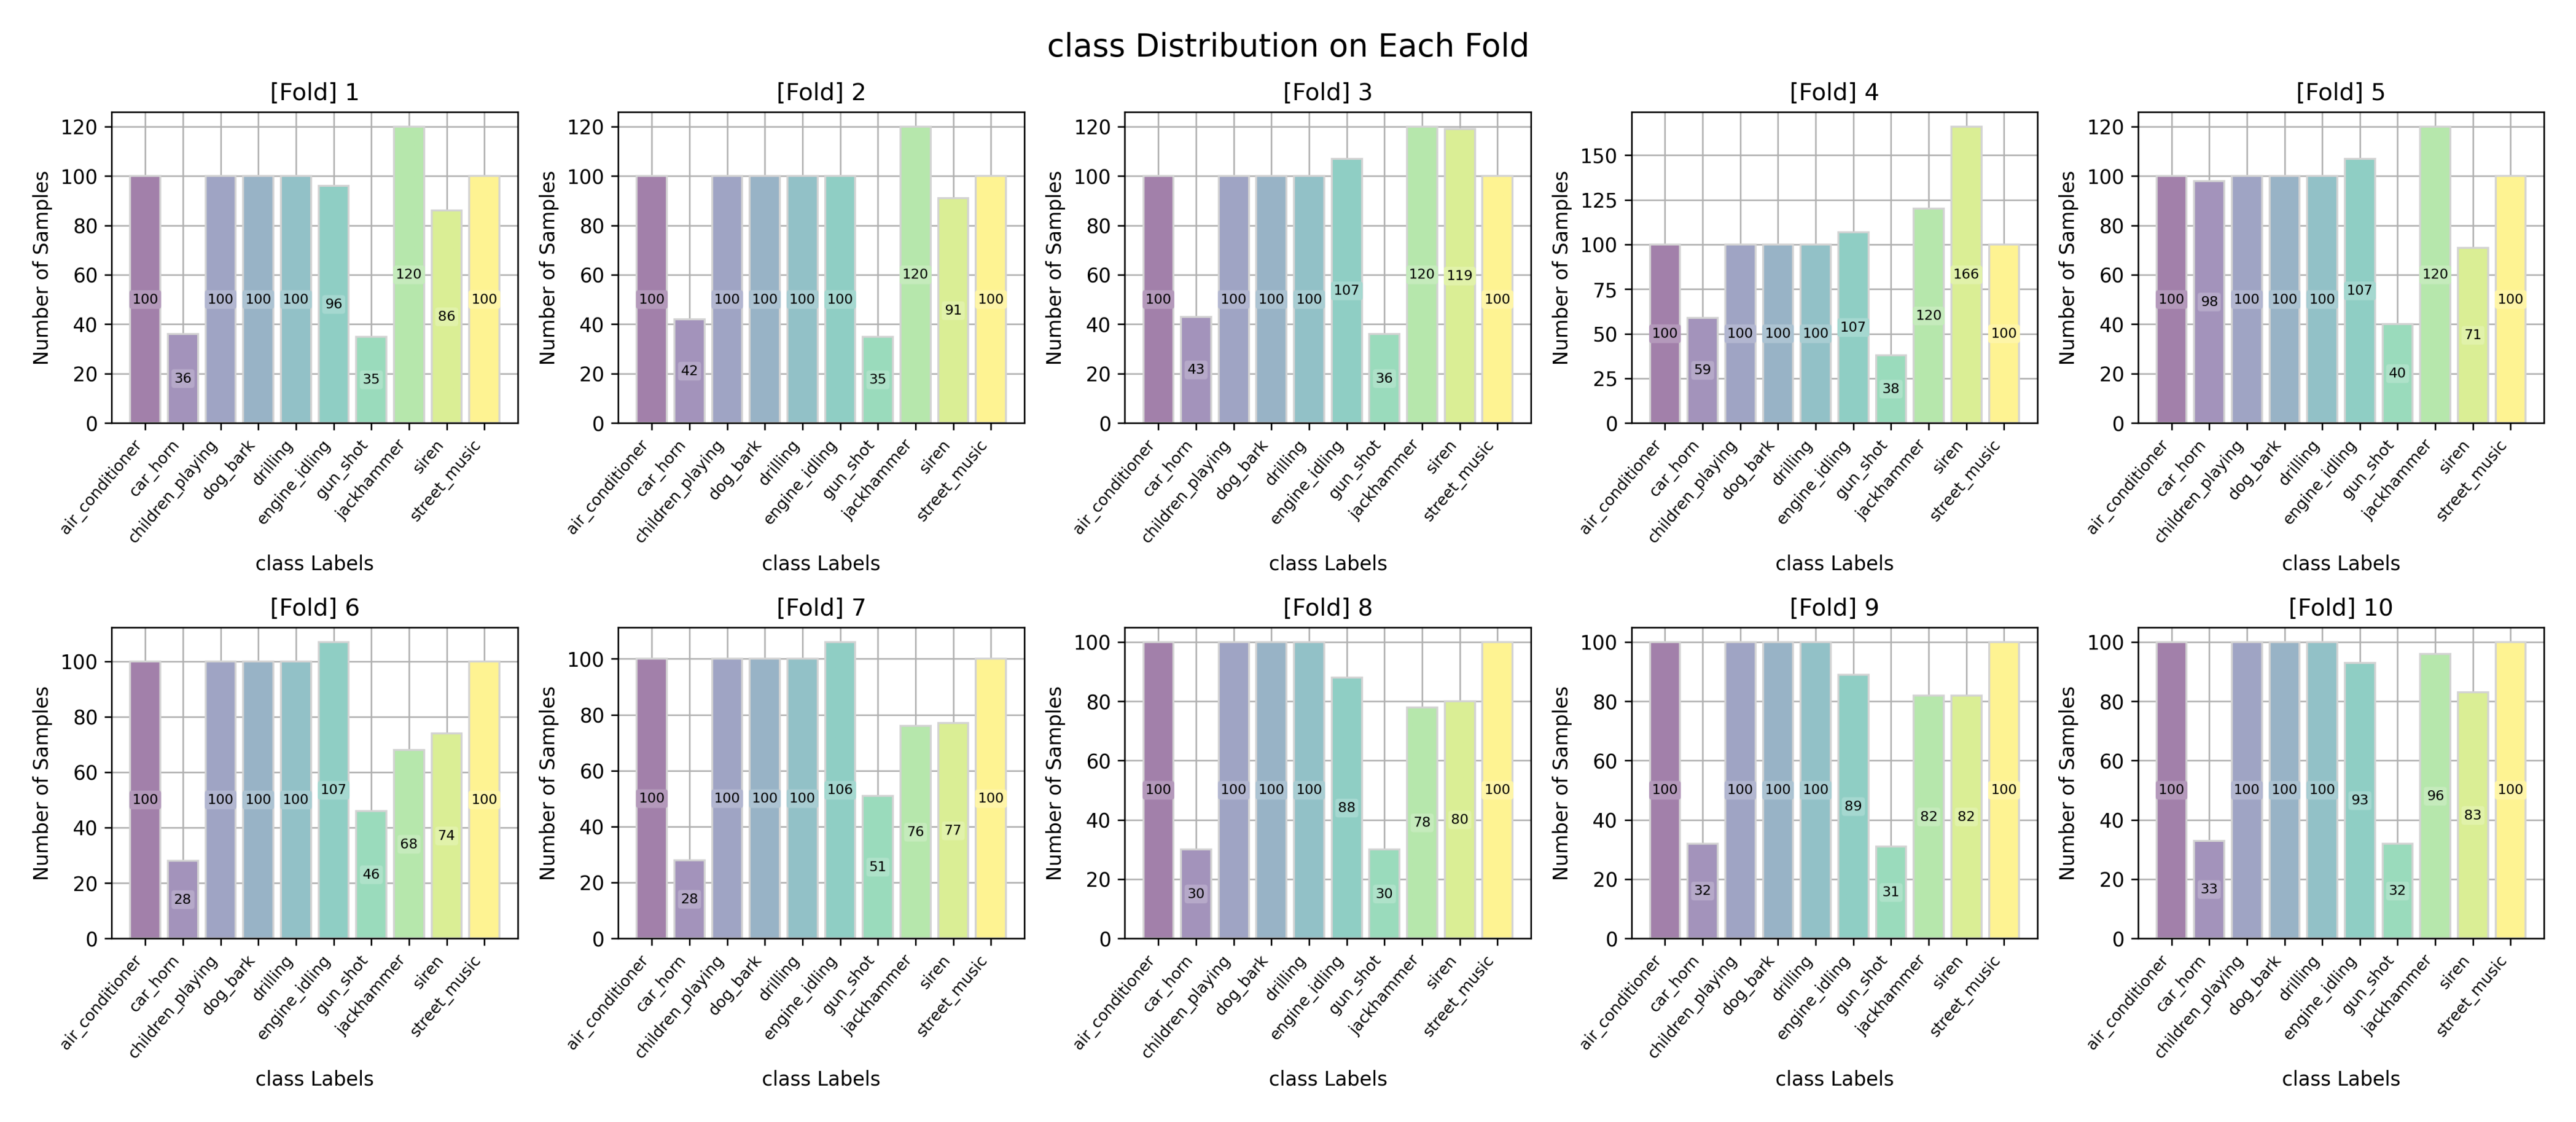

In [13]:
# Plot the class distribution per fold
plotFeatureDistributionByFold(df=df, classFeature='class', foldFeature='fold', pathsConfig=pathsConfig)

<div align="center">
    
---
## Data Preprocessing
---

</div>

> EXTRACT THE IMPORTANT FEATURES FROM THE AUDIO SAMPLES

---
### Sound Features
---

To accurately analyze and extract features from audio samples, we first need to load them properly. Using the librosa library, we can handle each audio file from the dataset with careful consideration of duration, sample rate, and zero-padding.

The target length is calculated as the product of the DURATION (4 seconds, as specified in the dataset) and the TARGET_SAMPLE_RATE.

We opted to increase the sample rate from the default 22,050 Hz to 44,100 Hz to capture higher-quality details, given the variety of sounds in the dataset — ranging from complex audio like street music to simpler noises like car horns. 

Consequently, zero-padding will ensure that all audio samples remain with a consistent length, standardizing the dataset for more reliable feature extraction. Moreover, this size consistency is crucial when training deep learning models, since they require a uniform input size across all samples.

In [14]:
# Load a audio
audioName = '101415-3-0-2.wav'
audioData = loadAudio(df_audio=df, audioSliceName=audioName, audioDuration=config['DURATION'], targetSampleRate=config['SAMPLE_RATE'], usePadding=True)
audioData.shape

(176400,)

In [15]:
# Show the audio associated with the selected file
showcaseAudio(df_audio=df, audioSliceName=audioName)

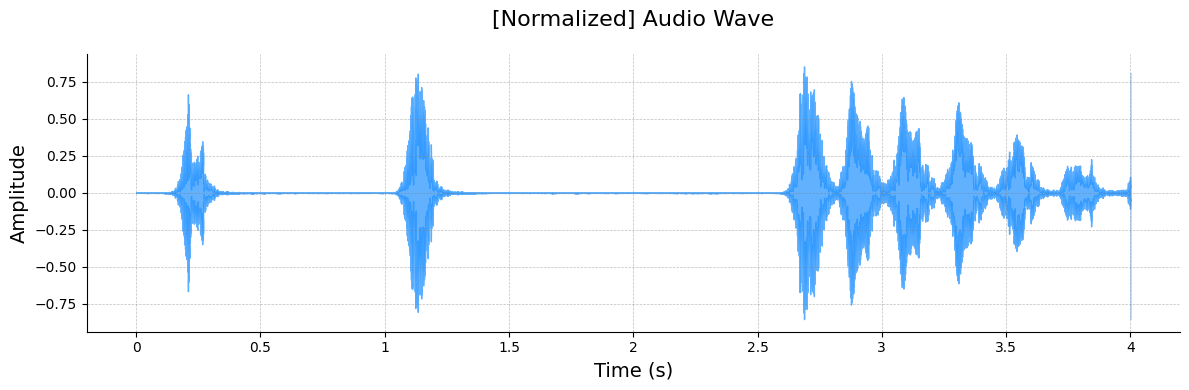

In [16]:
# Plot the Audio Wave
plotAudioWave(df_audio=df, audioSliceName=audioName, config=config)

---
### 1-Dimensional Features
---

#### &rarr; Zero-Crossing Rate (ZCR)

``Description`` : ZCR measures how often the signal changes sign (crosses zero) in a frame.

This is a time-domain feature that is particularly useful for distinguishing between different types of noise or impulsive sounds, such as car horns or dog barks, which have different temporal behaviors.

In [17]:
# Compute the Audio's Zero Crossing Rate
zeroCrossingRate = libr.feature.zero_crossing_rate(y=audioData)
print(zeroCrossingRate.shape)
# zeroCrossingRate

(1, 345)


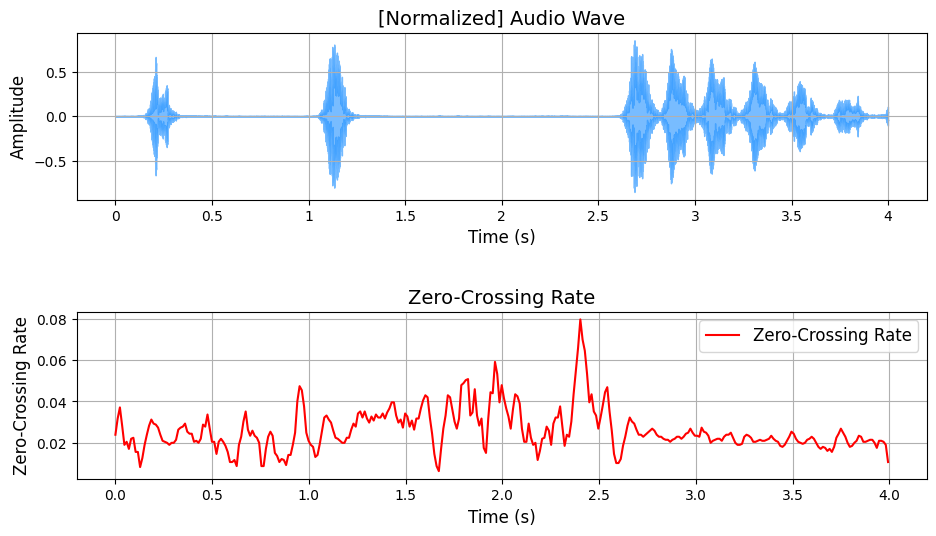

In [18]:
# Plot the Audio's Zero-Crossing Rate
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=zeroCrossingRate, featureName='Zero-Crossing Rate', yLabel='Zero-Crossing Rate', color='r', config=config)

#### &rarr; Spectral Centroid

``Description`` : The spectral centroid is the "center of mass" of the spectrum, giving an indication of where the energy of the sound is concentrated.

It helps in distinguishing between sounds with different frequency content (e.g., high-pitched sirens vs. low-pitched engine noises).

In [19]:
# Compute the Audio's Spectral Centroid
spectralCentroid = libr.feature.spectral_centroid(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralCentroid.shape)
# spectralCentroid

(1, 345)


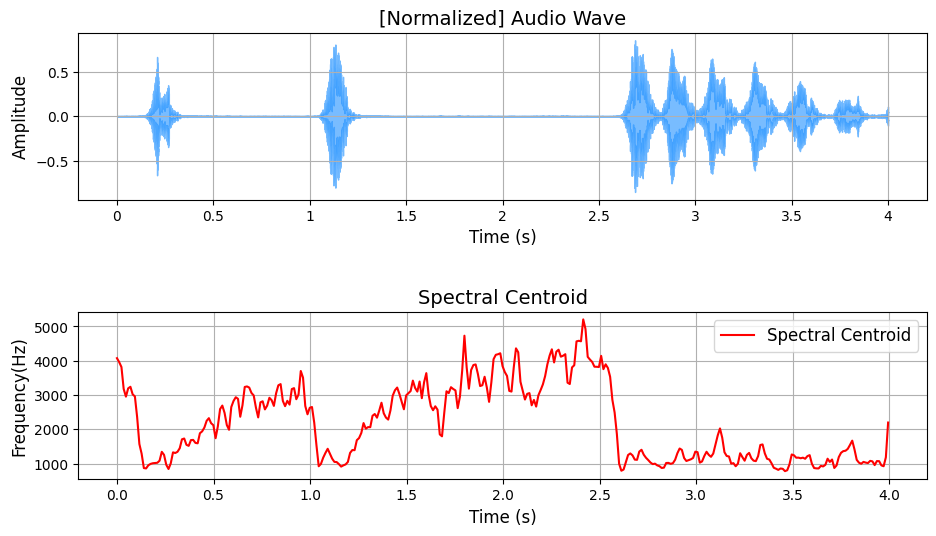

In [20]:
# Plot the Audio's Spectral Centroid
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralCentroid, featureName='Spectral Centroid', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Bandwidth

``Description`` : This measures the width of the spectrum (the difference between the lower and upper frequencies in a sound).

It helps distinguish sounds with wide frequency content (e.g., crowd noise) from those with narrow frequency content (e.g., beeps or alarms).

In [21]:
# Compute the Audio's Spectral Bandwidth
spectralBandwidth = libr.feature.spectral_bandwidth(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralBandwidth.shape)
# spectralBandwidth

(1, 345)


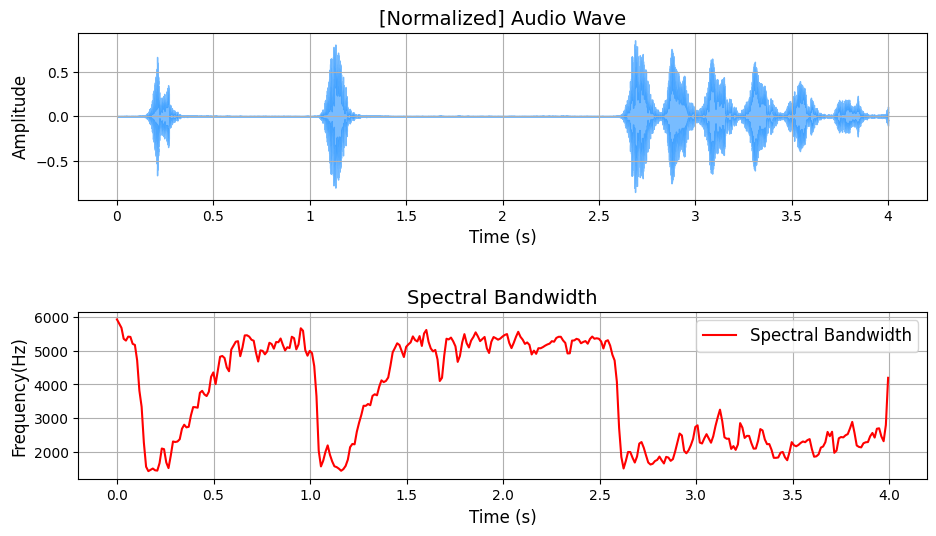

In [22]:
# Plot the Audio's Spectral Bandwidth
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralBandwidth, featureName='Spectral Bandwidth', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Flatness

``Description`` : Measures how noise-like or tonal a sound is by comparing the geometric and arithmetic means of the power spectrum.

Helps distinguish between tonal sounds (e.g., sirens, horns) and noise-like sounds (e.g., wind, traffic).

In [23]:
# Compute the Audio's Spectral Flatness
spectralFlatness = libr.feature.spectral_flatness(y=audioData)
print(spectralFlatness.shape)
# spectralFlatness

(1, 345)


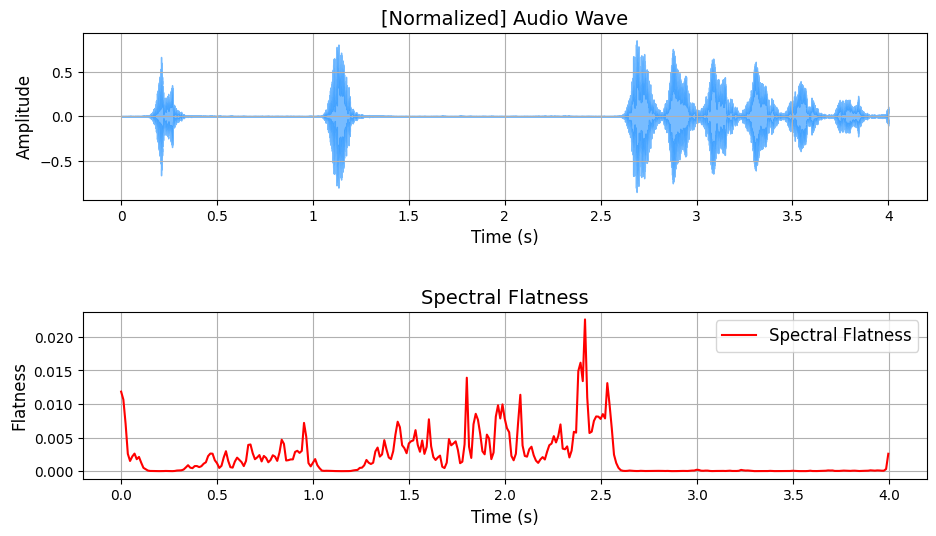

In [24]:
# Plot the Audio's Spectral Flatness
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralFlatness, featureName='Spectral Flatness', yLabel='Flatness', color='r', config=config)

#### &rarr; Spectral Roll-off

``Description`` : Spectral roll-off is the frequency below which a specified percentage (usually 85-90%) of the total spectral energy is contained.

It helps differentiate between high-frequency sounds (e.g., sharp noises like sirens or alarms) and low-frequency sounds (e.g., engine noise, rumbling).

In [25]:
# Compute the Audio's Spectral Roll-off
spectralRolloff = libr.feature.spectral_rolloff(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralRolloff.shape)
# spectralRolloff

(1, 345)


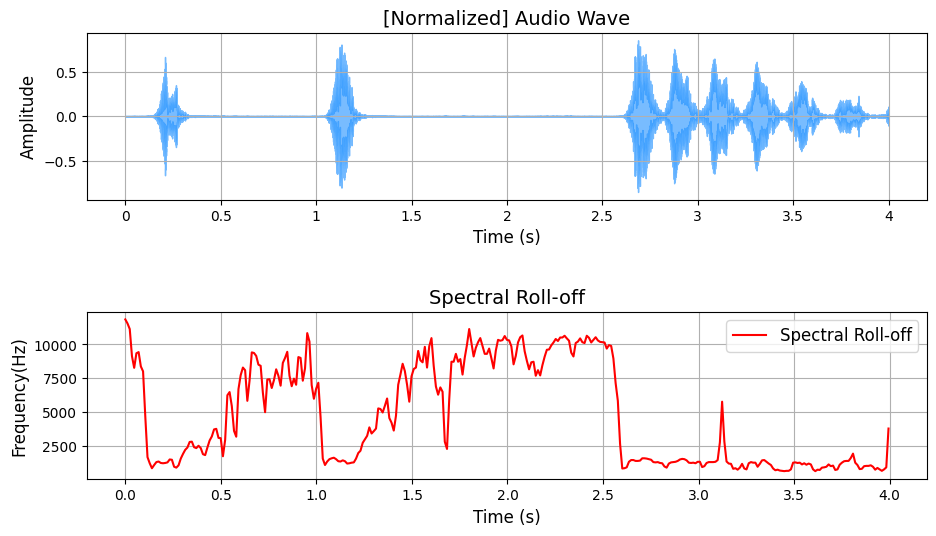

In [26]:
# Plot the Audio's Spectrall Roll-off
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralRolloff, featureName='Spectral Roll-off', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; RMS Energy

``Description`` : The Root Mean Square (RMS) energy is a measure of the signal's energy over time.

It is useful to distinguish between quiet and loud sounds and can help classify sounds with varying intensity, such as traffic or construction noise.

In [27]:
# Compute the Audio's RMS Energy
rms = libr.feature.rms(y=audioData)
print(rms.shape)
# rms

(1, 345)


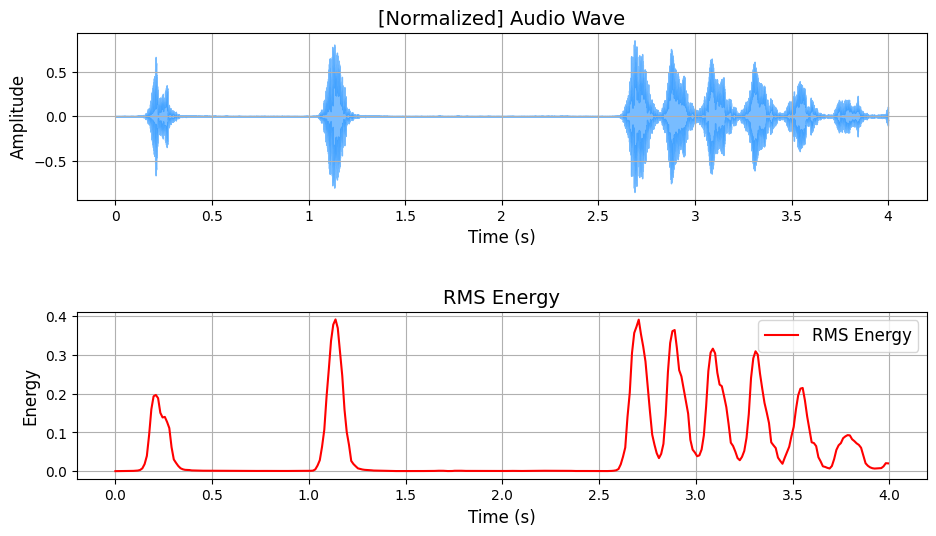

In [28]:
# Plot the Audio's RMS Energy
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=rms, featureName='RMS Energy', yLabel='Energy', color='r', config=config)

---
### 2-Dimensional Features
---

#### &rarr; Mel-Frequency Cepstral Coefficients (MFCC)

``Description`` : MFCCs represent the short-term power spectrum of an audio signal, emphasizing the perceptually relevant features for human hearing.

MFCCs are widely used in audio classification tasks, including speech recognition and environmental sound classification. They effectively capture the timbral texture of sounds, which is important for distinguishing different urban sound categories.

In [29]:
# Compute the MFC Coefficients
mfccs = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], n_mfcc=config['N_MFCC'])
print(mfccs.shape)
# mfccs

(13, 345)


#### &rarr; Chroma Features (Chroma STFT)

``Description`` : Chroma features represent the pitch class (e.g., C, C#, D, etc.) and are useful for identifying tonal and harmonic content in audio.

While chroma features are traditionally more useful for music, they can capture harmonic structure in urban sounds, especially those with tonal elements like sirens or honking.

In [30]:
# Compute the Chroma Features
chroma_stft = libr.feature.chroma_stft(y=audioData, n_chroma=config['N_CHROMA'], sr=config['SAMPLE_RATE'], n_fft=config['N_FFT'], hop_length=config['HOP_LENGTH'], win_length=config['WINDOW_LENGTH'])
print(chroma_stft.shape)
# chroma_stft

(12, 321)


In [31]:
list(np.mean(chroma_stft, axis=0))

[0.83141804,
 0.8265198,
 0.8190381,
 0.82776856,
 0.825432,
 0.8416849,
 0.8343449,
 0.7675987,
 0.78847265,
 0.88031244,
 0.6305122,
 0.9062235,
 0.49890682,
 0.41297567,
 0.42693496,
 0.26966265,
 0.19872189,
 0.3164734,
 0.25238505,
 0.2541032,
 0.257734,
 0.28547207,
 0.6313023,
 0.30131197,
 0.4005927,
 0.51200825,
 0.3574821,
 0.44329765,
 0.44314584,
 0.40263626,
 0.3672112,
 0.34404257,
 0.33420905,
 0.4382213,
 0.3976865,
 0.5849273,
 0.6600864,
 0.49710193,
 0.41583583,
 0.51075894,
 0.78016526,
 0.78745645,
 0.57023245,
 0.75636584,
 0.80067974,
 0.8558037,
 0.7901743,
 0.7103731,
 0.85621375,
 0.84324604,
 0.79866767,
 0.8885378,
 0.6307636,
 0.8162463,
 0.90126735,
 0.8699909,
 0.7547951,
 0.82254773,
 0.8230943,
 0.9346928,
 0.9052599,
 0.7383866,
 0.89805466,
 0.8519059,
 0.92737025,
 0.7531934,
 0.8407437,
 0.7989847,
 0.68478626,
 0.84064984,
 0.8503876,
 0.79097277,
 0.8233063,
 0.79478335,
 0.8619029,
 0.80892485,
 0.8531001,
 0.73231417,
 0.79471844,
 0.8258004,
 0

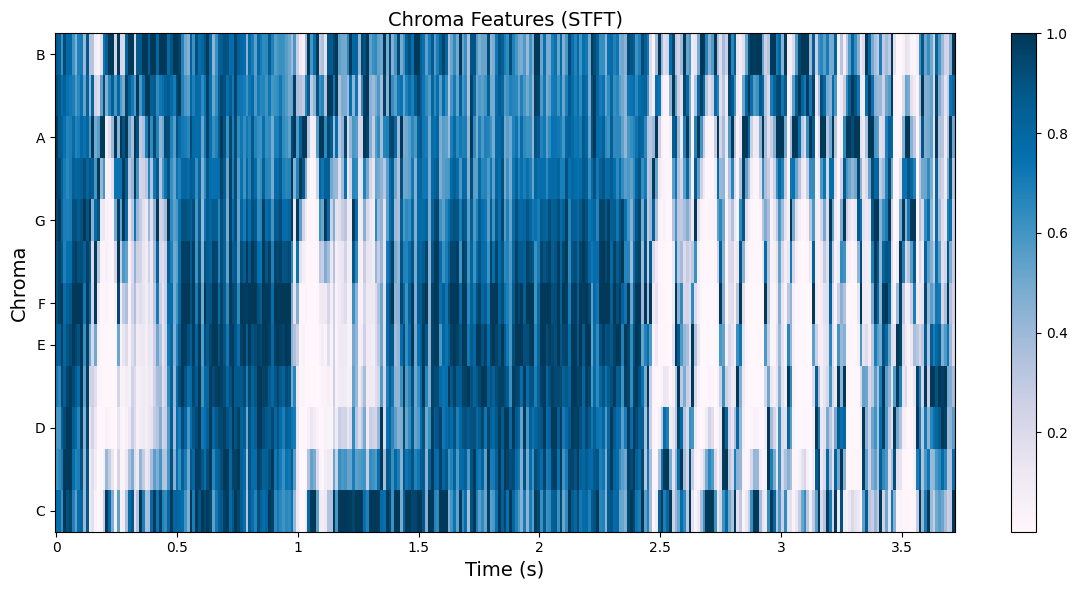

In [32]:
# Plot the audio's Chroma Features
plotChromaFeatures(audioData=audioData, config=config)

#### &rarr; Mel Spectrogram

``Description`` : A Mel spectrogram is a representation of the signal's power across different frequencies, scaled to the Mel scale (which mimics human auditory perception).

It is particularly useful for capturing the overall energy and frequency distribution of urban sounds. It’s a more detailed version of MFCCs, emphasizing the full frequency range.

In [33]:
# Compute the Mel Spectrogram
melSpectrogram = libr.feature.melspectrogram(y=audioData, sr=config['SAMPLE_RATE'])
print(melSpectrogram.shape)
# melSpectrogram

(128, 345)


In [34]:
np.mean(melSpectrogram, axis=1).shape

(128,)

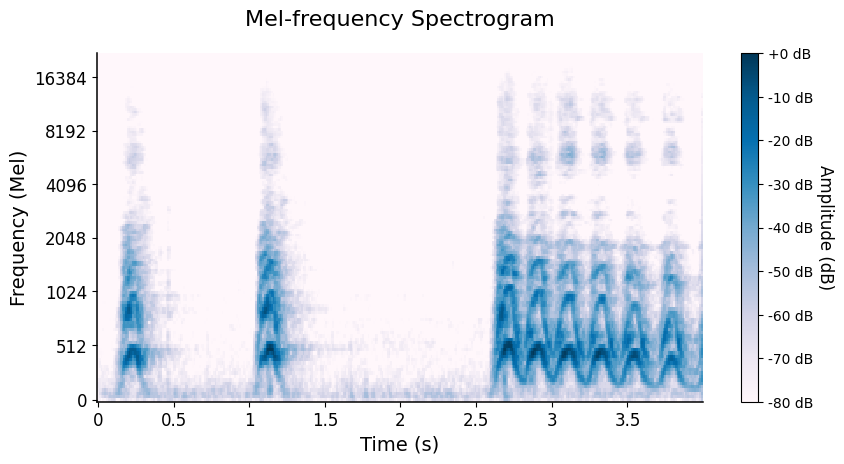

In [35]:
# Plot the Mel Spectrogram
plotMelSpectrogram(audioData, config['SAMPLE_RATE'])

#### &rarr; Spectral Contrast

``Description`` : Spectral contrast measures the difference between peaks and valleys in the sound spectrum.

Urban sounds tend to have diverse spectral profiles (e.g., the contrast between loud car horns and quieter ambient sounds), making spectral contrast useful for distinguishing between classes.

In [36]:
# Compute the Spectral Contrast
spectralContrast = libr.feature.spectral_contrast(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralContrast.shape)
# spectralContrast

(7, 345)


In [37]:
np.mean(spectralContrast, axis=0).reshape(1, -1).tolist()[0] == np.mean(spectralContrast, axis=0).tolist()

True

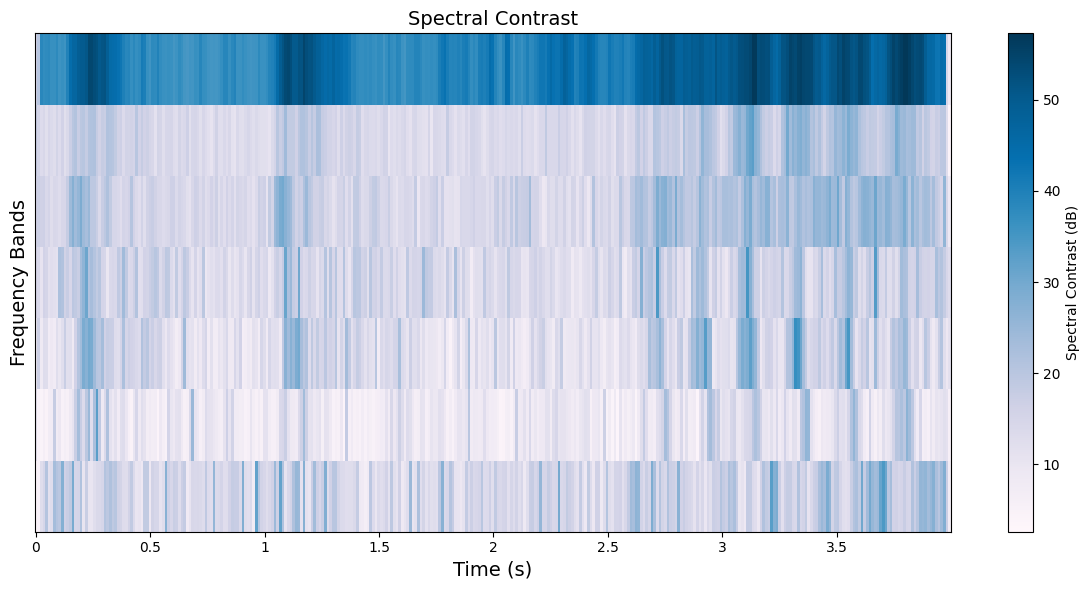

In [38]:
# Plot the Audio's Spectral Contrast
plotSpectralContrast(audioData=audioData, config=config)

---
## Data Pre-Processing and Preparation
---

> PERFORM DATA PREPROCESSING AND PREPARATION

In [39]:
# Extract all the 1-Dimensional and 2-Dimensional Features on each Fold
for fold in range(1, 11):
    # Performing 1 Dimensional feature extraction on the audio samples from each fold
    # extractAll1DimensionalData(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    
    # Performing 2 Dimensional feature extraction on the audio samples from each fold
    # extractAll2DimensionalData(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

    # Extract only MFCCs 
    extractMFCCs(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

    # Extract all the important features
    extractImportantFeatures(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

[Fold-1]	MFCC's have already been Extracted!
[Fold-1]	Important Features have already been Extracted!
[Fold-2]	MFCC's have already been Extracted!
[Fold-2]	Important Features have already been Extracted!
[Fold-3]	MFCC's have already been Extracted!
[Fold-3]	Important Features have already been Extracted!
[Fold-4]	MFCC's have already been Extracted!
[Fold-4]	Important Features have already been Extracted!
[Fold-5]	MFCC's have already been Extracted!
[Fold-5]	Important Features have already been Extracted!
[Fold-6]	MFCC's have already been Extracted!
[Fold-6]	Important Features have already been Extracted!
[Fold-7]	MFCC's have already been Extracted!
[Fold-7]	Important Features have already been Extracted!
[Fold-8]	MFCC's have already been Extracted!
[Fold-8]	Important Features have already been Extracted!
[Fold-9]	MFCC's have already been Extracted!
[Fold-9]	Important Features have already been Extracted!
[Fold-10]	MFCC's have already been Extracted!
[Fold-10]	Important Features have al

In [40]:
# extractImportantFeatures(audio_df=df, fold=1, config=config, pathsConfig=pathsConfig)

<div align="center">
    
---
## Model Architecture Definition
---

</div>

> ADD MODEL ARCHITECTURE DEFINITION

---
### Multi-Layered Perceptron (MLP)
---

> DEFINE THE NETWORK ARCHITECTURE

In [41]:
def createMLP():
    # TO BE IMPLEMENTED
    return None

---
### Convolutional Neural Network (CNN)
---

> DEFINE THE NETWORK ARCHITECTURE

In [42]:
def createCNN():
    # TO BE IMPLEMENTED
    return None

### YAMNET - PRETRAINED NETWORK

In [43]:
# YAMNET Details @ https://www.tensorflow.org/hub/tutorials/yamnet?hl=pt-br

# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

---
### [BONUS] MODEL (?)
---

> DEFINE THE NETWORK ARCHITECTURE

In [44]:
def createBonusModel():
    # TO BE IMPLEMENTED
    return None

<div align="center">
    
---
## Training Strategies
---

</div>

> ADD TRAINING STRATEGIES

In [45]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Please ensure TensorFlow GPU version is installed.")
    
# Clear GPU cache
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

GPU not found. Please ensure TensorFlow GPU version is installed.


<div align="center">
    
---
## Performance Evaluation
---

</div>

> ADD PERFORMANCE EVALUATION

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

LINKS:
- https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46
- https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

---
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`
    - [Pedro Afonseca](https://github.com/PsuperX) &#8594; `up202205394@edu.fc.up.pt`

---
---

<div align="center">

## TESTS

</div>

In [46]:
# Loading the mean mfccs from a singuar fold
fold = 1
# datasetName = 'MFCCs-Feature'
datasetName = 'Final-Features'
mfccs = pd.read_csv(pathsConfig['Datasets'][f'Fold-{fold}'][datasetName])
mfccs.head()

,audio,fold,Zero-Crossing Rate,Spectral Centroid,Spectral Bandwidth,Spectral Flatness,Spectral Roll-off,RMS Energy,MFCC,Chroma STFT,Mel Spectrogram,Spectral Contrast,target
0,101415-3-0-2.wav,1,"[0.02392578125, 0.03173828125, 0.037109375, 0....","[4073.29576610579, 3957.663676556724, 3815.347...","[5934.384636168281, 5806.395153660612, 5685.27...","[0.011839318089187145, 0.010658163577318192, 0...","[11843.26171875, 11541.796875, 11132.666015625...","[0.00023165112361311913, 0.0003064787888433784...","[-421.2201843261719, 85.28880310058594, 28.294...","[0.6317387223243713, 0.5694851279258728, 0.538...","[0.0008905880968086421, 0.00666288286447525, 0...","[16.711200827330476, 10.84708246770799, 15.076...",dog_bark
1,101415-3-0-3.wav,1,"[0.0224609375, 0.029296875, 0.03564453125, 0.0...","[3462.0156691409284, 3725.1271874850627, 3391....","[5259.5461872453725, 5501.169142687889, 5418.2...","[0.008688013069331646, 0.008732213638722897, 0...","[9366.943359375, 10314.404296875, 9366.9433593...","[0.00030560020240955055, 0.0004711924702860415...","[-395.1141662597656, 116.3168716430664, 43.765...","[0.491304874420166, 0.5235579609870911, 0.5570...","[0.000810613390058279, 0.006724657490849495, 0...","[18.363078375250073, 12.546554338105143, 15.01...",dog_bark
2,101415-3-0-8.wav,1,"[0.013671875, 0.02197265625, 0.02734375, 0.025...","[3283.1695173578164, 2366.440008160451, 1615.5...","[4838.51356961069, 4003.974012488502, 2723.716...","[0.012779070064425468, 0.0025244215503335, 0.0...","[7558.154296875, 4155.908203125, 1593.45703125...","[0.09354621917009354, 0.11235775053501129, 0.1...","[-437.91595458984375, 66.94352722167969, 16.55...","[0.6416203379631042, 0.6280611753463745, 0.650...","[0.0022949050180613995, 0.00977104902267456, 0...","[15.846617397767218, 9.560808993585251, 12.498...",dog_bark
3,102106-3-0-0.wav,1,"[0.0283203125, 0.0419921875, 0.05126953125, 0....","[3194.885375715173, 3044.413938679557, 2936.48...","[3809.1751102398857, 3461.925221998732, 3360.8...","[0.009605040773749352, 0.004005370195955038, 0...","[6610.693359375, 6395.361328125, 6244.62890625...","[0.012451985850930214, 0.014610644429922104, 0...","[-537.6240844726562, 59.329261779785156, -18.4...","[0.19029444456100464, 0.2306346893310547, 0.24...","[0.012946242466568947, 0.02832587994635105, 0....","[13.041173123916591, 12.399252071902078, 15.10...",dog_bark
4,102305-6-0-0.wav,1,"[0.0224609375, 0.02978515625, 0.03173828125, 0...","[2649.2473409988133, 2794.607919174997, 2559.9...","[3430.8352949263726, 3504.623650598662, 3353.2...","[0.0020661146845668554, 0.003668541321530938, ...","[6223.095703125, 6266.162109375, 5792.43164062...","[0.05955224484205246, 0.08514250814914703, 0.1...","[-514.0081787109375, 94.9853744506836, 14.3711...","[0.3679084777832031, 0.3529568314552307, 0.358...","[4.4291205406188965, 1.8299769163131714, 0.749...","[10.902814580490372, 8.601080946941895, 10.915...",gun_shot


In [47]:
mfccs.MFCC[0]

'[-421.2201843261719, 85.28880310058594, 28.294160842895508, 2.621643304824829, -13.181735038757324, 0.7228930592536926, 1.1512739658355713, -8.122461318969727, -9.273735046386719, -4.73956298828125, -7.198401927947998, -3.777961492538452, 2.0165936946868896]'

In [48]:
foo = [mfccs]
foo.extend([pd.read_csv(pathsConfig["Datasets"][f"Fold-{i}"][datasetName]) for i in range(2,11)])
mfccs = pd.concat(foo)

In [49]:
# Convert mfccs into numpy array
x = np.array(mfccs['MFCC'].apply(lambda x: ast.literal_eval(x)).tolist())

print(x.shape)

# Encode classes
encoder = LabelEncoder()
y = encoder.fit_transform(mfccs['target'])
y = to_categorical(y, num_classes=10)

indices = np.arange(len(x))

# Train-validation split
train_indices, test_indices = train_test_split(indices, stratify=y, random_state=0)

trainX, trainY = x[train_indices], y[train_indices]
testX, testY = x[test_indices], y[test_indices]

(8732, 13)


In [50]:
print(trainX.shape)
trainX

(6549, 13)


array([[-2.91297913e+02,  1.41143585e+02, -9.84363937e+00, ...,
        -4.40885210e+00,  8.73721719e-01, -3.73349786e+00],
       [-3.57088348e+02,  2.01317352e+02,  3.31977425e+01, ...,
         3.73192692e+00,  4.97032309e+00,  3.78649473e+00],
       [-2.93170288e+02,  1.26519485e+02, -6.45281448e+01, ...,
        -4.01250124e+00, -8.44377327e+00, -2.37124367e+01],
       ...,
       [-1.62214905e+02,  1.77763748e+02, -4.36784821e+01, ...,
         5.39655924e+00,  1.18004537e+00, -7.10084343e+00],
       [-6.35345886e+02,  4.22368469e+01, -1.30449858e+01, ...,
        -8.58827114e+00,  3.65308809e+00, -1.45534945e+00],
       [-1.55435410e+02,  1.55015549e+02, -3.13971119e+01, ...,
        -2.15484695e+01, -4.65789825e-01, -1.72880917e+01]])

In [51]:
print(trainY.shape)
trainY

(6549, 10)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [52]:
# Define the model
model = Sequential([
    layers.Dense(2048, activation='relu', input_shape=(config['N_MFCC'],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(10, activation='softmax')
])

In [53]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=5e-4,
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

In [56]:
# Train the model
history = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8244 - loss: 0.4984 - val_accuracy: 0.8346 - val_loss: 0.4838 - learning_rate: 5.0000e-04
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8326 - loss: 0.4945 - val_accuracy: 0.8543 - val_loss: 0.4532 - learning_rate: 5.0000e-04
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8442 - loss: 0.4485 - val_accuracy: 0.8530 - val_loss: 0.4161 - learning_rate: 5.0000e-04
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8535 - loss: 0.4365 - val_accuracy: 0.8493 - val_loss: 0.4280 - learning_rate: 5.0000e-04
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8471 - loss: 0.4386 - val_accuracy: 0.8621 - val_loss: 0.4201 - learning_rate: 5.0000e-04
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8470 - loss: 0.4423 - val_accuracy: 0.8690 - val_loss: 0.4118 - learning_rate: 5.0000e-04
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/ste

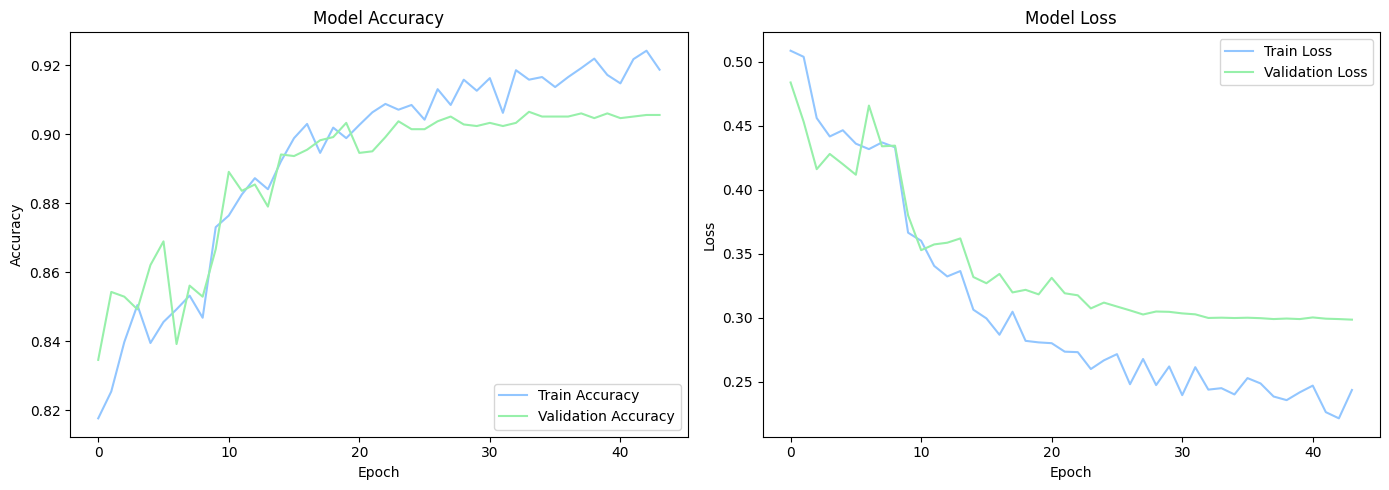

In [57]:
# Plot the Model Training Performance
plotNetworkTrainingPerformance(history)

In [ ]:
# %pip install scikeras

# WARNING: se usarmos pipelines e cross_validate do sklearn trainX pode n caber na memoria e ai fica complicado :/

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import PredefinedSplit, cross_validate
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

classifier = KerasClassifier(
    build_fn=lambda: model,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0,
)

split = PredefinedSplit(df.iloc[train_indices]["fold"])
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', classifier)          # TensorFlow model
])

cv_results = cross_validate(pipeline, trainX, trainY, cv=split)
# history = pipeline.fit(trainX, trainY)

In [ ]:
history = cv_results.best_estimator_.named_steps["model"].history_

# Plot training & validation accuracy and loss values
plotNetworkTrainingPerformance(history)